### Simulations:
- Compare NTI as group assignment transitions from unbalanced to balanced
- Compare NTI as cross-group edge weights decrease
- Fair-accuracy tradeoff as fairness penalty grows for 2-SBM and fair vs. unfair group assignment
    - 2x2 figure: Top two SBMs with colors/shapes associated with group, bottom two fair/accuracy plots vs. penalty
- Compare NTI as bias in samples increases
- Fair-accuracy tradeoff: Fairness penalty grows for 2-SBM and fair vs. unfair group assignment for two figures (2-SBM)
    - 2x2 figure: Top two are SBM with colors/shapes associated with group, bottom two are associated fair/accuracy plots as penalty grows
- US senate network: Infer network for increasing penalty, compare to baseline?

- Include multiple groups
- GFT of fair vs. unfair group assignments in 2-SBM
- Compare different graph signals models


#### To do:
- Parameter tuning
- Compare different bias types
- Compare $\ell_1$ norm with reweighted $\ell_1$ norm
- Compare different numbers of groups $G$

In [ ]:
from utils import *
from opt import *
import matplotlib.pyplot as plt

C:\Users\andrei.buciulea\AppData\Local\Temp\ipykernel_18708\2656525565.py:61: RuntimeWarning: invalid value encountered in true_divide
  A_fnti = Theta_hat/np.max(Theta_hat)
C:\Users\andrei.buciulea\AppData\Local\Temp\ipykernel_18708\2656525565.py:61: RuntimeWarning: invalid value encountered in true_divide
  A_fnti = Theta_hat/np.max(Theta_hat)
C:\Users\andrei.buciulea\AppData\Local\Temp\ipykernel_18708\2656525565.py:61: RuntimeWarning: invalid value encountered in true_divide
  A_fnti = Theta_hat/np.max(Theta_hat)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


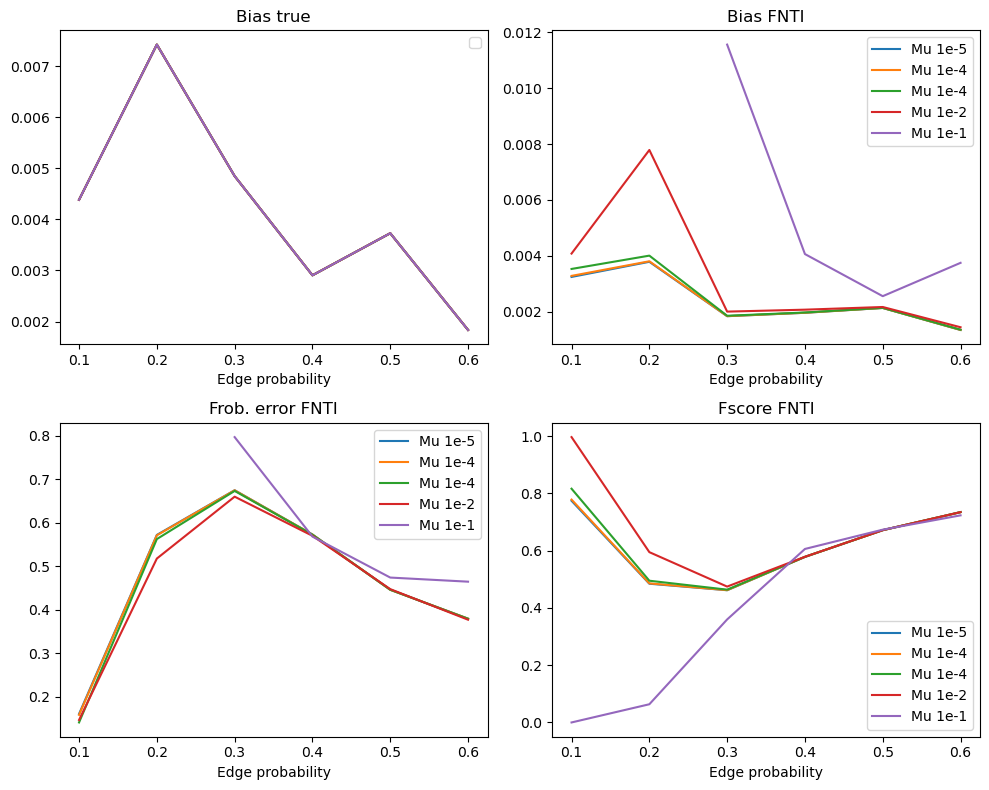

In [22]:
import numpy as np

# Base experiment
# --------------------------------
verbose = True

N = 40
G = 3
edge_prob = [0.1, 0.2, 0.3, 0.4,0.5,0.6]
#edge_prob = [0.1]
L = 3
M = 1000000

opt_bias_type = 'dp'
eval_bias_type = 'dp'
REWEIGHTED = False
UPPER_BOUND = False
norm_scale = lambda A: np.sum(A[0]) if np.sum(A[0]) != 0 else 1
# --------------------------------

# Parameters
labels = ['Mu 1e-5', 'Mu 1e-4','Mu 1e-4','Mu 1e-2','Mu 1e-1']
mus1 = np.logspace(-5,-1,5)
mu2 = 10
eta = 1e-5

nep = len(edge_prob)
nm1 = len(mus1)
T = 10
frob_fnti = np.zeros((nep,nm1,T))
f1_fnti = np.zeros((nep,nm1,T))
bias_fnti = np.zeros((nep,nm1,T))
bias_true = np.zeros((nep,nm1,T))
# Main loop
for t in range(T): 
    for i, ep in enumerate(edge_prob):

        # Generate data
        A = generate_connected_er(N, ep)
        A_norm = A / norm_scale(A)
        Z = np.eye(G)[np.sort(np.random.choice(G, N))].T
        Ng = np.sum(Z, axis=1).astype(int)

        #Estimate covariance
        Sigma, Theta = create_mtp2_cov(A)
        Theta_od = Theta*(1-np.eye(N))
        X = np.random.multivariate_normal(np.zeros(N), Sigma, M)
        C_est = X.T@X/M

        # Estimate covariance
        #H = create_filter(A=A, L=L)
        #C = create_poly_cov(H=H)
        #X = poly_samples(H=H, M=M)
        #C_est = est_cov(X=X)

        for k, m1 in enumerate(mus1):
            Theta_hat = FairGLASSO_fista(C_est, m1, eta, mu2, Z, bias_type='dp',
                                                epsilon=0.1, iters=1000,EARLY_STOP=False, prec_type=None)
            np.fill_diagonal(Theta_hat,0)
            Theta_hat = np.abs(Theta_hat)
            A_fnti = Theta_hat/np.max(Theta_hat)

            

            A_norm_fnti = A_fnti / norm_scale(A_fnti)
            #plt.imshow(A_fnti)
            #plt.colorbar()
            # Compute metrics
            bias_true[i,k,t] = compute_bias(A_norm, Z, bias_type=eval_bias_type)
            bias_fnti[i,k,t] = compute_bias(A_norm_fnti, Z, bias_type=eval_bias_type)
            frob_fnti[i,k,t] = compute_frob_err(A_fnti, A)
            f1_fnti[i,k,t] = compute_f1_score(A_fnti, A, eps_thresh=0.2)

            # Print results
            #print(f"Bias (true): {bias_true[i,k]:.5f}")
            #print(f"Frob. error (FNTI): {frob_fnti[i,k]:.5f}")
            #print(f"Bias (FNTI): {bias_fnti[i,k]:.5f}")
            #print(f"F1-score (FNTI): {f1_fnti[i,k]:.5f}")



        # --------------------------------
        #vmax = np.max([np.max(A_norm),np.max(np.abs(A_norm_fnti))])
        #madimshow(A_norm,axis=False,vmin=0,vmax=vmax,figsize=(3,3))
        #madimshow(np.abs(A_norm_fnti),axis=False,vmin=0,vmax=vmax,figsize=(3,3))
        # --------------------------------

b_t = np.mean(bias_true, axis=2)
b_f = np.mean(bias_fnti, axis=2)
f_f = np.mean(frob_fnti, axis=2)
f1_f = np.mean(f1_fnti, axis=2)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot
axs[0, 0].plot(edge_prob,b_t)
axs[0, 0].set_title('Bias true')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Edge probability')
# Second subplot
for l, line in enumerate(b_f.T):
    axs[0, 1].plot(edge_prob, line, label=labels[l])
axs[0, 1].set_title('Bias FNTI')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Edge probability')

# Third subplot
for l, line in enumerate(f_f.T):
    axs[1, 0].plot(edge_prob, line, label=labels[l])
axs[1, 0].set_title('Frob. error FNTI')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Edge probability')
# Fourth subplot
for l, line in enumerate(f1_f.T):
    axs[1, 1].plot(edge_prob, line, label=labels[l])
axs[1, 1].set_title('Fscore FNTI')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Edge probability')
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()




In [8]:

np.mean(bias_fnti, axis=2)

array([[0.00199941, 0.00295554, 0.00385074,        nan,        nan],
       [0.00170339, 0.00189016, 0.00162919, 0.17277192,        nan],
       [0.00323522, 0.0027141 , 0.00278971, 0.01485325,        nan],
       [0.00220237, 0.00235104, 0.00277472, 0.00122933,        nan],
       [0.00258671, 0.00223915, 0.0017729 ,        nan,        nan],
       [0.0016587 , 0.00201606, 0.00281153, 0.00360784,        nan]])

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot
axs[0, 0].plot(edge_prob,bias_true)
axs[0, 0].set_title('Bias true')
axs[0, 0].legend()
axs[0,0].set_xlabel('Edge probability')
# Second subplot
for l, line in enumerate(bias_fnti.T):
    axs[0, 1].plot(edge_prob, line, label=labels[l])
axs[0, 1].set_title('Bias FNTI')
axs[0, 1].legend()
axs[0,0].set_xlabel('Edge probability')

# Third subplot
for l, line in enumerate(frob_fnti.T):
    axs[1, 0].plot(edge_prob, line, label=labels[l])
axs[1, 0].set_title('Frob. error FNTI')
axs[1, 0].legend()
axs[0,0].set_xlabel('Edge probability')
# Fourth subplot
for l, line in enumerate(f1_fnti.T):
    axs[1, 1].plot(edge_prob, line, label=labels[l])
axs[1, 1].set_title('Fscore FNTI')
axs[1, 1].legend()
axs[0,0].set_xlabel('Edge probability')
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()